### 0.0 Load dependencies & functions

In [1]:
import re
from typing import List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import spacy
import fasttext
from huggingface_hub import hf_hub_download
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

%matplotlib inline

In [2]:
def subplot_histograms(
        df: pd.DataFrame,
        main_title: str,
        list_of_titles: List[str],
        xlabels,
        list_of_colors: List[str]
    ):
    """
    This creates histogram subplots for each rating (1-5).
    Each subplot represents the distribution of the dates at which the reviews were written.

    ### Arguments
    - `df`: The input dataframe. It must have a `score` and `at` column.
    - `main_title`: The title of the chart generated.
    - `list_of_titles`: A list of titles e.g., '4-Star Rating','5-Star Rating', etc.
    - `xlabels`: The x-axis label of the chart.
    - `list_of_colors`: A list of color palette codes to use.
    """
    df = df.copy() # best practice to ensure we don't alter the original dataframe

    fig, ax = plt.subplots(5, 1, figsize=(8,10), sharex=True, sharey=True)
    for i in range(5):
        ax[i].hist(df[df['score']==(i+1)]['at'], bins=50, color=list_of_colors[i])
        ax[i].set_title(list_of_titles[i], weight='bold')
        ax[i].set_xlabel(xlabels)
        ax[i].set_ylabel('Frequency')
    fig.suptitle(main_title, fontsize=15, weight='bold')
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)

In [3]:
def plot_wordcloud(
        target: int,
        title: str,
        df: pd.DataFrame,
        text_col_in_df: str,
        max_words: int = 50,
    ):
    """
    This is a function to plot a wordcloud of the most frequently occurring 
    words based on whether the review is negative (1) or positive (0).

    ### Arguments
    - `target`: Whether the review is negative (1) or positive (0).
    - `title`: The title of the WordCloud chart generated.
    - `df`: The input dataframe. It must have a `content` column.
    - `text_col_in_df`: The text column in the input dataframe.
    - `max_words`: The maximum no. of words in the wordcloud.
    """
    df = df.copy() # best practice to ensure we don't alter the original dataframe
    
    text = df[df['target']==target][text_col_in_df] 

    wordcloud = WordCloud(width=2000, 
                          height=1000, 
                          background_color='white', 
                          max_words=max_words,
                          stopwords=STOPWORDS
                ).generate(' '.join(text)) # Remove stopwords
    
    plt.figure(figsize=(10,8))
    plt.title(title, fontsize=15, weight='bold')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off') # Removes the axis
    plt.tight_layout()

In [4]:
def barplot_cvec(
        df: pd.DataFrame,
        target: int,
        titles: List[str],
        color: str,
        xlimit: Tuple[int, int]
    ):
    """
    Plots top 20 uni-grams and bi-grams for positive and negative reviews.
    
    ### Arguments
    - `df`: The input dataframe
    - `target`: Whether the review is negative (1) or positive (0).
    - `title`: A list of titles 
    - `color`: Color palette to use for charts.
    - `xlimit`: Horizontal axis limits
    """
    df = df.copy() # best practice to ensure we don't alter the original dataframe
    
    words_series = df[df['target']==target]['content_stem']
    
    fig, ax = plt.subplots(1, 2, figsize=(25,12))
    
    ngram = [(1,1),(2,2)] # The ngrams that we would like to plot
    
    for i in range(2):
            
        # Use CountVectorizer to tokenize the text, 
        cvec = CountVectorizer(stop_words='english', ngram_range=ngram[i])

        # Save the tokens in a dataframe
        cvec_df = pd.DataFrame(cvec.fit_transform(words_series).todense(), columns=cvec.get_feature_names_out())
        sum_words = cvec_df.sum(axis=0) # Sum up the no. of occurences for each word
        top_words = sum_words.sort_values(ascending=False).head(20)
        top_words.sort_values(ascending=True).plot(kind='barh', color=color, ax=ax[i])

        # Adjust plot aesthetics
        ax[i].set_title(titles[i], size=25, weight='bold')
        ax[i].set_xlabel('Count', size=20)
        ax[i].set_xlim(xlimit) # Setting a limit so that the barplots are comparable
        ax[i].tick_params(axis='both', which='major', labelsize=20)
        ax[i].tick_params(axis='both', which='minor', labelsize=20)

    plt.tight_layout()

In [5]:
def stem_text(
        raw_text: str,
        stopwords_list: List[str] = [],
    ) -> str:
    """
    This is a function to convert raw text to a string of meaningful words.

    ### Arguments
    - `raw_text`: The input text to pre-process.
    - `stopwords_list`: A list of stopwords to be added in the stopwords list.

    ### Returns
    A pre-processed string.
    """
  
    # Remove HTML tags
    review_text = BeautifulSoup(raw_text).get_text()
    
    # Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # Convert words to lower case and split each word up
    words = letters_only.lower().split()
    
    # Searching through a set is faster than searching through a list 
    # Hence, we will convert stopwords to a set
    stops = set(stopwords.words('english'))
    
    # Adding on stopwords that were appearing frequently in both positive and negative reviews 
    stops.update(stopwords_list)
    
    # Remove stopwords
    meaningful_words = [w for w in words if w not in stops]
        
    # Instantiate PorterStemmer
    p_stemmer = PorterStemmer()
    
    # Stem words
    meaningful_words = [p_stemmer.stem(w) for w in meaningful_words]        
   
    # Join words back into one string, with a space in between each word
    return(" ".join(meaningful_words))

In [30]:
# download stopwords for NLTK
# nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/faiq0913/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# !python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 1.0 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [6]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

In [7]:
# load dataset
reviews = pd.read_csv('../data/genshin_impact_reviews.csv', parse_dates=['at','repliedAt'])

### 1.0 Data Cleaning & Pre-processing

#### 1.1 Create a target variable

The goal is to classify positive and negative app reviews. Negative reviews can reveal critical features that are missing from Genshin Impact's app or even bring to light the presence of bugs on the app. This will require immediate action from Hoyoverse. As such, priority will be placed on the prediction of negative sentiment. We will assign the negative reviews (scores 1-3) to class 1, and the positive reviews (scores 4-5) to class 0.

In [8]:
# Defining the target variable using scores
reviews['target'] = reviews['score'].map(lambda x: 1 if x < 4 else 0)

In [9]:
# Check the count of our target variable
reviews['target'].value_counts()

target
1    5185
0    3647
Name: count, dtype: int64

In [10]:
reviews.head(3)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sort_order,app_id,target
0,12b832b8-a76a-4292-a916-cbda39384153,BAI Li,https://play-lh.googleusercontent.com/a-/ALV-U...,I've been playing this game for about two year...,1,277,5.0.0_26041933_26161852,2024-09-29 18:04:07,We sincerely apologize for your unsatisfactory...,2024-09-30 16:43:34,5.0.0_26041933_26161852,most_relevant,com.miHoYo.GenshinImpact,1
1,106b7231-3a41-454e-812b-6307445ed11a,ami amin,https://play-lh.googleusercontent.com/a-/ALV-U...,I was really looking forward to playing this g...,1,18,5.0.0_26041933_26161852,2024-09-29 09:55:17,NaN,NaT,5.0.0_26041933_26161852,most_relevant,com.miHoYo.GenshinImpact,1
2,7f339f1c-a3ac-46ab-95b1-7a2991476824,Tahlia Tucker,https://play-lh.googleusercontent.com/a-/ALV-U...,The rating I could just give is a 1 since I ca...,1,17,5.0.0_26041933_26161852,2024-09-19 06:09:10,We sincerely apologize for your unsatisfactory...,2024-09-25 19:04:25,5.0.0_26041933_26161852,most_relevant,com.miHoYo.GenshinImpact,1


#### 1.2 Pre-processing

Prior to pre-processing, let's find frequently occurring words in both positive and negative sentiments. This can help us find which words to remove and add to the Stopwords list.

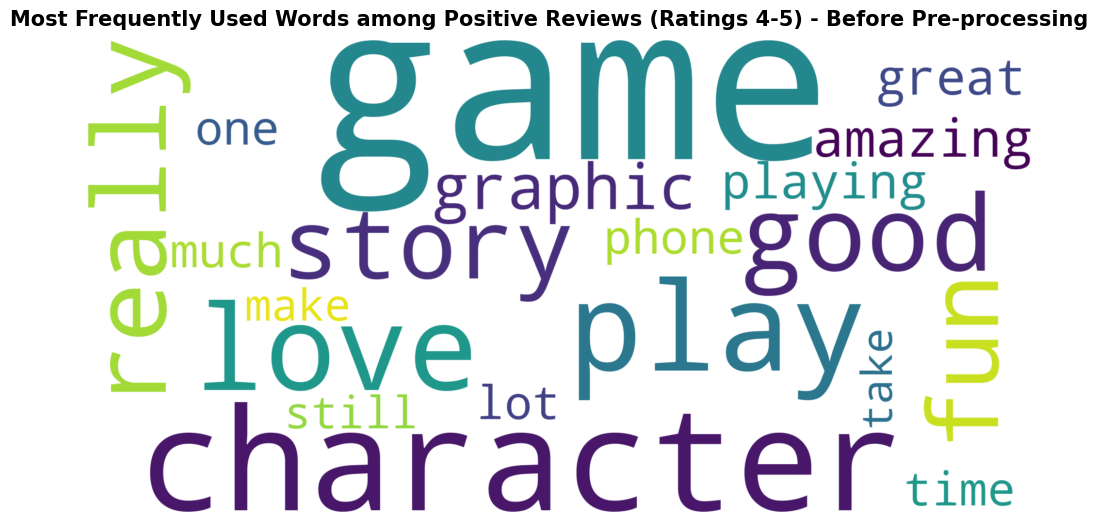

In [11]:
# Wordcloud of the 50 most frequently occurring words among positive reviews
plot_wordcloud(
    target=0,
    title='Most Frequently Used Words among Positive Reviews (Ratings 4-5) - Before Pre-processing',
    df=reviews,
    text_col_in_df='content',
    max_words=20,
)

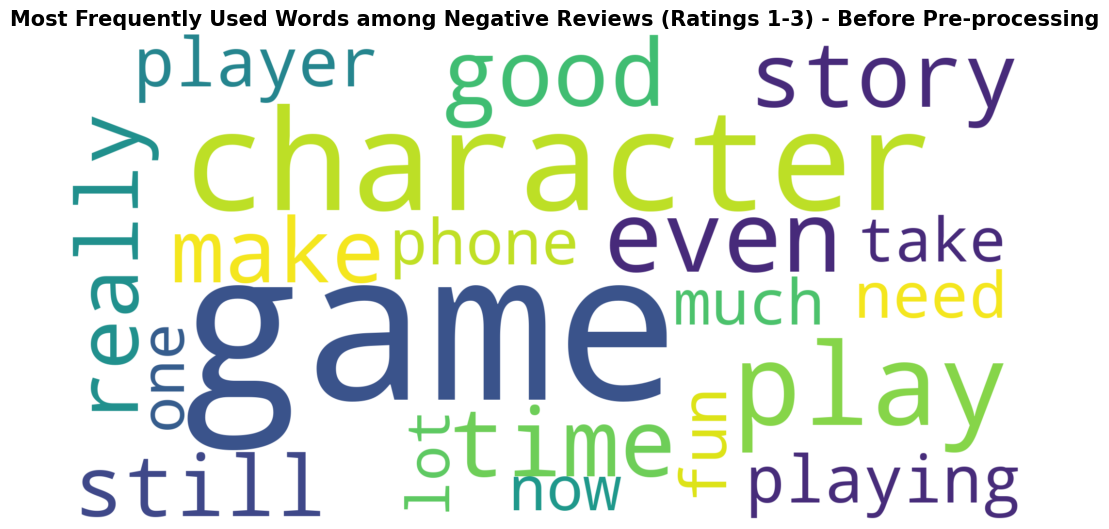

In [12]:
# Wordcloud of the 50 most frequently occurring words among positive reviews
plot_wordcloud(
    target=1,
    title='Most Frequently Used Words among Negative Reviews (Ratings 1-3) - Before Pre-processing',
    df=reviews,
    text_col_in_df='content',
    max_words=20,
)

Next, we will perform pre-processing to transform our text into a more digestible form for our classifier. The steps are as follows:
- Remove HTML tags
- Use regular expression to remove special characters and numbers
- Lowercase words
- Use NLTK to remove stopwords
- Remove frequently occurring words that appear in both positive and negative sentiments, like 'character', 'game', 'play', 'really', etc.
- Use NLTK to stem words to their root form.

In [13]:
stopwords_list = ['genshin', 'character', 'characters', 'game', 'play', 'player', 'playing', 'make', 'really', 'good']

# Pre-process the raw text
reviews['content_stem'] = reviews['content'].map(lambda x: stem_text(raw_text=x, stopwords_list=stopwords_list))

/tmp/ipykernel_221315/300972406.py:17: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_text).get_text()


In [14]:
reviews.loc[0]['score']

1

In [15]:
# This is the original text of the first review in our dataset
reviews.loc[0]['content']

"I've been playing this game for about two years, for the stunning graphics, well-developed characters, plot, and exceptional open-world design. However, the unskippable boring quest dialogues are disturbing and unnecessary, so a skip button would be a great. The gacha system is decent, but with new characters introduced every update, even four-star characters are hard to obtain. five-stars in endgame content are impossible to obtain without extensive grinding. The game is outdated, unpleasant."

In [16]:
# This is how the text looks like after stemming
reviews.loc[0]['content_stem']

'two year stun graphic well develop plot except open world design howev unskipp bore quest dialogu disturb unnecessari skip button would great gacha system decent new introduc everi updat even four star hard obtain five star endgam content imposs obtain without extens grind outdat unpleas'

#### 1.3 Remove reviews that do not have any meaningful words

After pre-processing, we notice that there are some reviews that do not have any meaningful words left. As these reviews largely consists of only emojis or Chinese characters, these reviews returned blank fields after stemming. In other words, the length of these reviews after pre-processing, was 0. Given that these reviews will not add value to our model's training, we will remove them from our dataset. 

In [17]:
# Find the number of meaningful words in each review
reviews['content_clean_len'] = reviews['content_stem'].str.split().map(len)

In [18]:
# There are 203 reviews that do not have any meaningful words
reviews[reviews['content_clean_len']==0].shape

(204, 16)

In [19]:
# View reviews that do not have any meaningful words
reviews[reviews['content_clean_len']==0]['content']

1018                                                👎👎👎👎👎
1022    Геншин это донатерская помойка, в которой Орор...
1041              زبان فارسی نداره حال نمیده متوجه نمیشید
1077                                                   그냥
1083                                    умрі скатіна🤣🤣🤣🫵🫵
                              ...                        
8810                                       Very very good
8817                                               සමාලලි
8819                                                 Good
8828                       رجائا اضافه الغه العربيه للعبه
8829                                            Good game
Name: content, Length: 204, dtype: object

In [20]:
# Drop these reviews that do not have any meaningful words
reviews = reviews.drop(reviews[reviews['content_clean_len']==0].index)

In [21]:
# Reindex the dataframe
reviews.reset_index(drop=True, inplace=True)

#### 1.4 Remove reviews that are non-English or gibberish

We have identified several reviews that were written in non-English or simply gibberish. As we would like to train and test our model with only English text, we will remove these reviews to reduce the noise in our dataset.

In [ ]:
# this is quite a big file ~1GB!
model_path = hf_hub_download(repo_id="facebook/fasttext-language-identification", filename="model.bin")

In [9]:
model_path

'/home/faiq0913/.cache/huggingface/hub/models--facebook--fasttext-language-identification/snapshots/3af127d4124fc58b75666f3594bb5143b9757e78/model.bin'

In [22]:
model_path = '/home/faiq0913/.cache/huggingface/hub/models--facebook--fasttext-language-identification/snapshots/3af127d4124fc58b75666f3594bb5143b9757e78/model.bin'

In [23]:
model = fasttext.load_model(model_path)

In [24]:
# take one sample
reviews.loc[666]['content']

"Please, when basing a nation off of a culture with a variety of skin tones, don't make every single character except one pale. It's disappointing and disrespectful, not to mention the fact that some of those white characters are based off of dieties in Africa. Represent the people properly. People in every server across the world have been begging for this."

In [25]:
model.predict(reviews.loc[666]['content'])

(('__label__eng_Latn',), array([0.99997735]))

In [26]:
reviews['language'] = reviews['content'].map(lambda x: model.predict(x)[0][0])

In [27]:
reviews['language'].value_counts()

language
__label__eng_Latn    8170
__label__yue_Hant      77
__label__ind_Latn      48
__label__kor_Hang      43
__label__deu_Latn      34
                     ... 
__label__luo_Latn       1
__label__dan_Latn       1
__label__epo_Latn       1
__label__knc_Latn       1
__label__als_Latn       1
Name: count, Length: 67, dtype: int64

A cursory glance yields that the **classification of English text isn't perfect**. Nonetheless, for the sake of time, we will proceed as is as manually looking for English texts would be too time consuming.

In [28]:
reviews.loc[~reviews['language'].str.contains('eng')]

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sort_order,app_id,target,content_stem,content_clean_len,language
200,68d434aa-109e-4fb0-8ec6-824a0e09f6d0,Ren Jie Leo,https://play-lh.googleusercontent.com/a-/ALV-U...,"For the very last time, STOP TELLING ME THERE ...",1,8,5.1.0_27118081_27297621,2024-10-20 11:21:37,"We sincerely apologize for this issue, Travele...",2024-10-21 17:36:45,5.1.0_27118081_27297621,most_relevant,com.miHoYo.GenshinImpact,1,last time stop tell data error code theat unin...,16,__label__yue_Hant
719,255d478e-4343-4308-b64a-b400bf862ac5,Fedora Mede,https://play-lh.googleusercontent.com/a-/ALV-U...,I'VE BEEN PLAYING GENSHIN FOR A VERY LONG TIME...,1,2,4.8.0_24603909_24822834,2024-07-24 04:25:53,NaN,NaT,4.8.0_24603909_24822834,most_relevant,com.miHoYo.GenshinImpact,1,long time would give five star rate recent get...,41,__label__yue_Hant
1017,4a58b101-881f-4e17-b394-c476679dd56c,Shams Sharif,https://play-lh.googleusercontent.com/a/ACg8oc...,No Macdonald,1,1,5.1.0_27118081_27297621,2024-10-27 06:30:13,NaN,NaT,5.1.0_27118081_27297621,newest,com.miHoYo.GenshinImpact,1,macdonald,1,__label__spa_Latn
1020,acb8ed6a-1c04-49e4-9261-3dddc84d22c3,Kori Chiuyy,https://play-lh.googleusercontent.com/a-/ALV-U...,"Game berat anying, sekali updated 10GB pler",1,0,NaN,2024-10-27 01:48:46,NaN,NaT,NaN,newest,com.miHoYo.GenshinImpact,1,berat ani sekali updat gb pler,6,__label__ind_Latn
1024,1ed4f2d9-ff58-4869-9f59-d681979bab0b,Reim,https://play-lh.googleusercontent.com/a-/ALV-U...,Mid,1,3,4.0.0_16983586_17100363,2024-10-26 19:31:13,NaN,NaT,4.0.0_16983586_17100363,newest,com.miHoYo.GenshinImpact,1,mid,1,__label__est_Latn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8595,035fb2bc-a0f4-4cf3-85d3-ba1a01e0a900,Fara Pradina,https://play-lh.googleusercontent.com/a-/ALV-U...,Coolio,5,0,5.0.0_26041933_26161852,2024-10-14 17:39:27,NaN,NaT,5.0.0_26041933_26161852,newest,com.miHoYo.GenshinImpact,0,coolio,1,__label__hrv_Latn
8596,e267c540-2b6a-4ca9-bc6a-d3443e6886ec,Bonn Avery,https://play-lh.googleusercontent.com/a-/ALV-U...,ITS SOO BEAUTIFUL 😍.,5,0,5.1.0_27118081_27297621,2024-10-14 17:05:31,"Hello Traveler, thank you for supporting Gensh...",2023-10-26 19:32:05,5.1.0_27118081_27297621,newest,com.miHoYo.GenshinImpact,0,soo beauti,2,__label__kor_Hang
8611,06d8ca2b-d87c-40b3-8bbb-47da20eb9b9a,miraj uddinpubg,https://play-lh.googleusercontent.com/a-/ALV-U...,OP,5,0,NaN,2024-10-14 11:12:47,NaN,NaT,NaN,newest,com.miHoYo.GenshinImpact,0,op,1,__label__vie_Latn
8619,29f789ad-0a9b-4e70-998c-16e202a385f0,Ahmedali,https://play-lh.googleusercontent.com/a-/ALV-U...,Nice,5,0,5.0.0_26041933_26161852,2024-10-14 05:44:21,NaN,NaT,5.0.0_26041933_26161852,newest,com.miHoYo.GenshinImpact,0,nice,1,__label__ron_Latn


In [29]:
reviews_cleaned = reviews.loc[reviews['language'].str.contains('eng')]

reviews_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8170 entries, 0 to 8627
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              8170 non-null   object        
 1   userName              8170 non-null   object        
 2   userImage             8170 non-null   object        
 3   content               8170 non-null   object        
 4   score                 8170 non-null   int64         
 5   thumbsUpCount         8170 non-null   int64         
 6   reviewCreatedVersion  5967 non-null   object        
 7   at                    8170 non-null   datetime64[ns]
 8   replyContent          1090 non-null   object        
 9   repliedAt             1090 non-null   datetime64[ns]
 10  appVersion            5967 non-null   object        
 11  sort_order            8170 non-null   object        
 12  app_id                8170 non-null   object        
 13  target                8

In [30]:
reviews_cleaned.head(3)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sort_order,app_id,target,content_stem,content_clean_len,language
0,12b832b8-a76a-4292-a916-cbda39384153,BAI Li,https://play-lh.googleusercontent.com/a-/ALV-U...,I've been playing this game for about two year...,1,277,5.0.0_26041933_26161852,2024-09-29 18:04:07,We sincerely apologize for your unsatisfactory...,2024-09-30 16:43:34,5.0.0_26041933_26161852,most_relevant,com.miHoYo.GenshinImpact,1,two year stun graphic well develop plot except...,45,__label__eng_Latn
1,106b7231-3a41-454e-812b-6307445ed11a,ami amin,https://play-lh.googleusercontent.com/a-/ALV-U...,I was really looking forward to playing this g...,1,18,5.0.0_26041933_26161852,2024-09-29 09:55:17,NaN,NaT,5.0.0_26041933_26161852,most_relevant,com.miHoYo.GenshinImpact,1,look forward work chromebook got past main dow...,23,__label__eng_Latn
2,7f339f1c-a3ac-46ab-95b1-7a2991476824,Tahlia Tucker,https://play-lh.googleusercontent.com/a-/ALV-U...,The rating I could just give is a 1 since I ca...,1,17,5.0.0_26041933_26161852,2024-09-19 06:09:10,We sincerely apologize for your unsatisfactory...,2024-09-25 19:04:25,5.0.0_26041933_26161852,most_relevant,com.miHoYo.GenshinImpact,1,rate could give sinc even get instal get downl...,30,__label__eng_Latn


#### 1.5 Create a train and test set

20% of the original dataset will be set aside and used as a test set. This will be useful in evaluating our model's performance on unseen data.

We will use stratification to preserve the class representation in our train and test set.

In [31]:
# As we would like to stratify our target variable, we will need to first assign X and y
X = reviews_cleaned[[cols for cols in reviews_cleaned.columns if cols != 'target']]
y = reviews_cleaned['target']

In [32]:
# Perform a train_test_split to create a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [33]:
# Merge X_train and y_train back together using index
train = pd.merge(X_train, y_train, left_index=True, right_index=True)

# Merge X_test and y_test back together using index
test = pd.merge(X_test, y_test, left_index=True, right_index=True)

In [34]:
# Reindex the train and test set
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [35]:
# 6536 documents in our training set
train.shape

(6536, 17)

In [36]:
# 1634 documents in our training set
test.shape

(1634, 17)

In [37]:
# Check split in class labels for training set
train['target'].value_counts(normalize=True)

target
1    0.595777
0    0.404223
Name: proportion, dtype: float64

In [38]:
# Check split in class labels for validation set
test['target'].value_counts(normalize=True)

target
1    0.595471
0    0.404529
Name: proportion, dtype: float64

Finally, after data cleaning, we now have 6536 reviews for training and 1634 reviews in our test set. The class representation is consistent across the train and test set, with 40.5~% of the data belonging to class 0 (positive sentiment) and 59.5~% belonging to class 1 (negative sentiment).

### 2.0 Exploratory Data Analysis

We will perform EDA to draw insights from our training set. This step is also crucial in helping us determine if any more pre-processing is necessary before training the model.

#### 2.1 Wordclouds: Most frequently used words (after pre-processing)

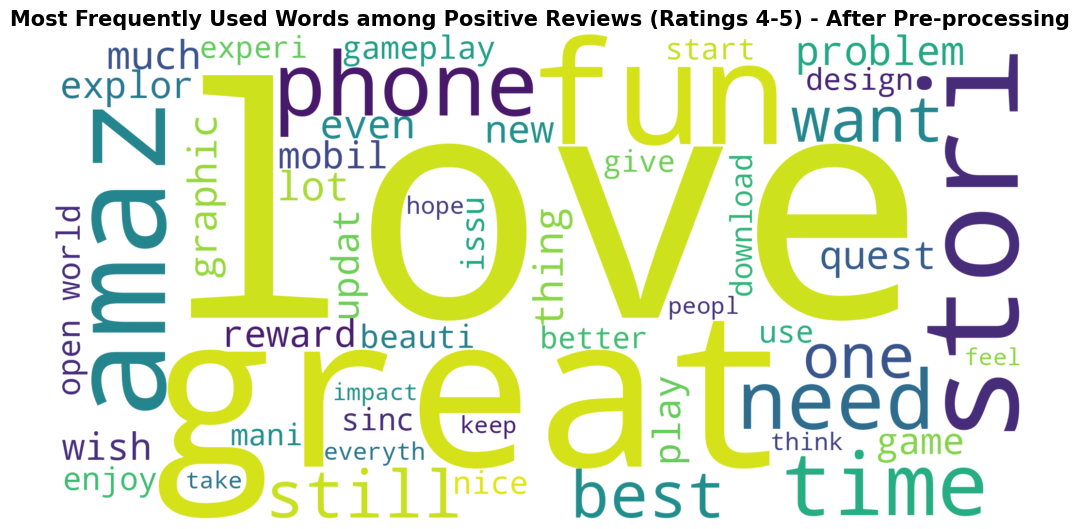

In [39]:
# Wordcloud of the 50 most frequently occurring words among positive reviews
plot_wordcloud(
    target=0,
    title='Most Frequently Used Words among Positive Reviews (Ratings 4-5) - After Pre-processing',
    df=reviews_cleaned,
    text_col_in_df='content_stem',
    max_words=50,
)

The words 'love', 'fun' and 'great' appear as the top words in the positive reviews. Very mindful, very demure. ✨

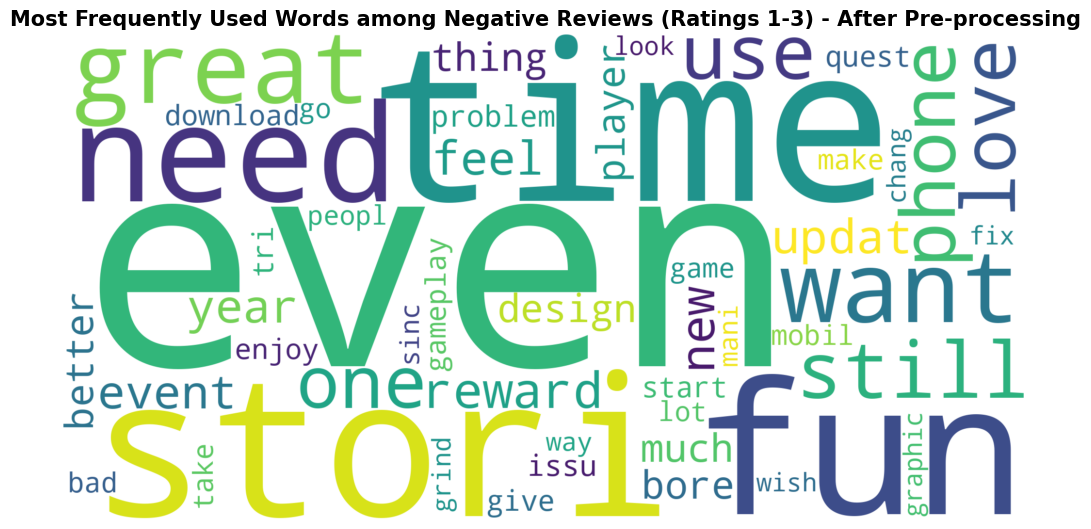

In [40]:
# Wordcloud of the 50 most frequently occurring words among negative reviews
plot_wordcloud(
    target=1,
    title='Most Frequently Used Words among Negative Reviews (Ratings 1-3) - After Pre-processing',
    df=reviews_cleaned,
    text_col_in_df='content_stem',
    max_words=50,
)

The words 'time', 'even' (which may have been the stemmed form of 'event'/'events') and 'stori' (which may refer to Genshin's story content) are the words among negative reviews.

#### 2.2 Number of meaningful words

Let's now compare the length of the reviews among positive vs negative sentiments.

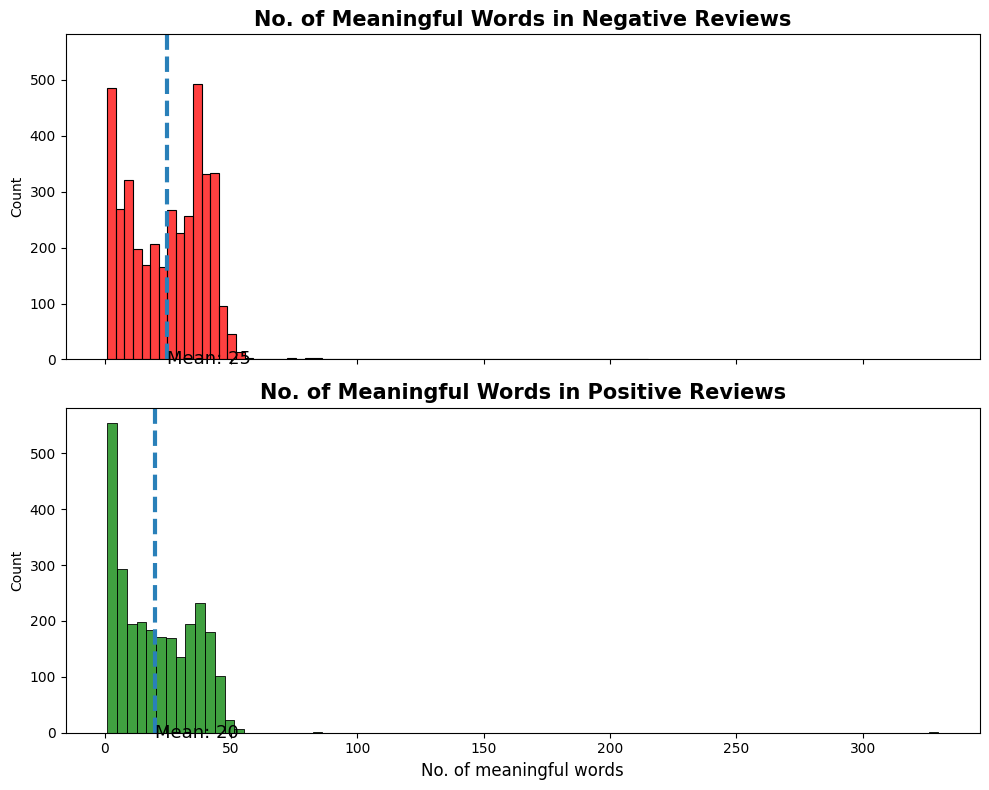

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True, sharey=True)

# Plots the distribution of the length of negative reviews
neg_len = train[train['target']==1]['content_clean_len']
sns.histplot(neg_len, color='red', ax=ax[0])
ax[0].axvline(neg_len.mean(), linestyle='dashed', linewidth=3, c='#2980B9') # Plot the mean line
ax[0].text(
    x=neg_len.mean(),
    y=0.08,
    s=f'Mean: {round(neg_len.mean())}', 
    horizontalalignment='left', 
    verticalalignment='center',
    fontsize=13,
)
ax[0].set_title('No. of Meaningful Words in Negative Reviews', fontsize=15, fontweight='bold')
ax[0].set_xlabel('No. of meaningful words', size=12)

# Plots the distribution of the length of positive reviews
pos_len = train[train['target']==0]['content_clean_len']
sns.histplot(pos_len, color='green', ax=ax[1])
ax[1].axvline(pos_len.mean(), linestyle='dashed', linewidth=3, c='#2980B9') # Plot the mean line
ax[1].text(
    x=pos_len.mean(),
    y=0.08,
    s=f'Mean: {round(pos_len.mean())}', 
    horizontalalignment='left', 
    verticalalignment='center',
    fontsize=13,
)
ax[1].set_title('No. of Meaningful Words in Positive Reviews', fontsize=15, fontweight='bold')
ax[1].set_xlabel('No. of meaningful words', size=12)
plt.tight_layout()

**Both distributions are bi-modal** (slightly for the positive reviews), with only a small proportion of posts that have >50 meaningful words. In fact, only 0.3% of positive reviews and 1% of negative reviews have more than 50 meaningful words. The average number of meaningful words in a negative review (25 words) is slightly higher than that in a positive review (21 words). There is also a noticeable higher variance in the number of meaningful words among negative reviews than positive reviews (which appear slightly uniform after 5 meaningful words), suggesting that dissatisfied players are more likely to write slightly longer reviews.

In [42]:
# Number of reviews that had >40 meaningful words
train[train['content_clean_len']>50]['target'].value_counts().sort_index()

target
0     9
1    41
Name: count, dtype: int64

In [43]:
train.target.value_counts()

target
1    3894
0    2642
Name: count, dtype: int64

In [44]:
# Only 0.4% of positive reviews have > 50 meaningful words
9/2642

0.0034065102195306586

In [45]:
# 1.5% negative reviews have > 50 meaningful words
41/3894

0.010529019003595274

#### 2.3 Time frame of the reviews written

We will compare the distributions of the review dates across various ratings, 1-5.

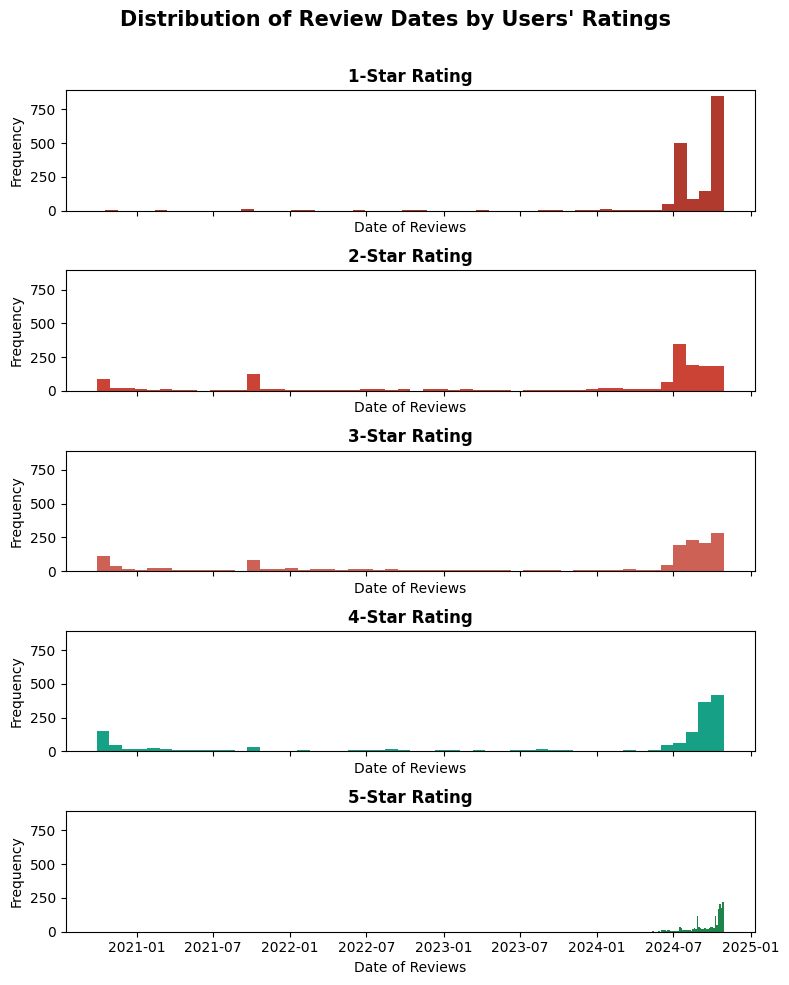

In [46]:
subplot_histograms(
    df=reviews_cleaned,
    main_title="Distribution of Review Dates by Users' Ratings",
    list_of_titles=['1-Star Rating','2-Star Rating','3-Star Rating','4-Star Rating','5-Star Rating'], 
    xlabels='Date of Reviews',
    list_of_colors = ['#B03A2E','#CB4335','#CD6155','#16A085','#1E8449']
)

The distributions of review dates differ across various rating scores (moreso for 5-Star ratings). While the data collected for 5-star ratings are all dated in the year 2024, reviews wiith other ratings are dated back to 2021 (near the game's launch, 28th September 2020). In an ideal world, we would like the reviews for each rating score to be collected in equal quantities, over the same time period. However, given that the majority of users gave the game a 5-Star rating, the data collection for negative reviews had to go back further in time. This was to obtain a balanced class training set, consisting of a relatively equal split between positive and negative reviews.

#### 2.4 Number of thumbs up received

Users can show their approval by giving a "thumbs up" to reviews on Genshin Impact's app. A higher number of thumbs up received from the community will suggest that several others have also been experiencing the same issues.

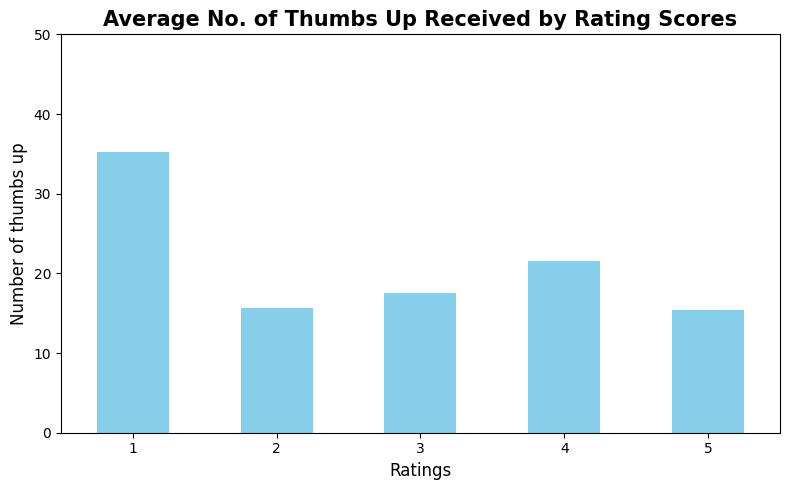

In [47]:
# Group by rating scores and find the average no. of thumbs up per score
train.groupby('score')['thumbsUpCount'].mean().plot(kind='bar', figsize=(8,5), color='skyblue')
plt.xlabel('Ratings', fontsize=12)
plt.xticks(rotation=0)
plt.ylabel('Number of thumbs up', fontsize=12)
plt.ylim(0,50)
plt.title('Average No. of Thumbs Up Received by Rating Scores', fontsize=15, weight='bold')
plt.tight_layout()

Negative reviews with 1-Star ratings receive more thumbs up on average. This is likely due to widespread consensus of Genshin Impact's flaws across the community. We'll see if we can quantify this later on.

In [48]:
# Show the top 5 reviews that received the highest number of thumbs up
train[['content','thumbsUpCount','score']].sort_values(by='thumbsUpCount', ascending=False).head()

,content,thumbsUpCount,score
2707,"Exploration is good, characters and weapons ar...",4511,1
348,For years now we have begged for a skip dialog...,3874,1
2233,It's a lovely game!! The graphics are beautifu...,3590,4
5961,The game forces you to sit through extremely l...,3124,2
1338,Been playing for 2 years and I've tried genshi...,2949,5


#### 2.5 Top uni-grams and bi-grams

We will use CountVectorizer to tokenize our textual data and generate bar plots for the top uni-grams and bi-grams seen in each sentiment. Are there unique words that will help us to distinguish between positive and negative sentiments? Or, are there certain words that are occurring in both sentiments?

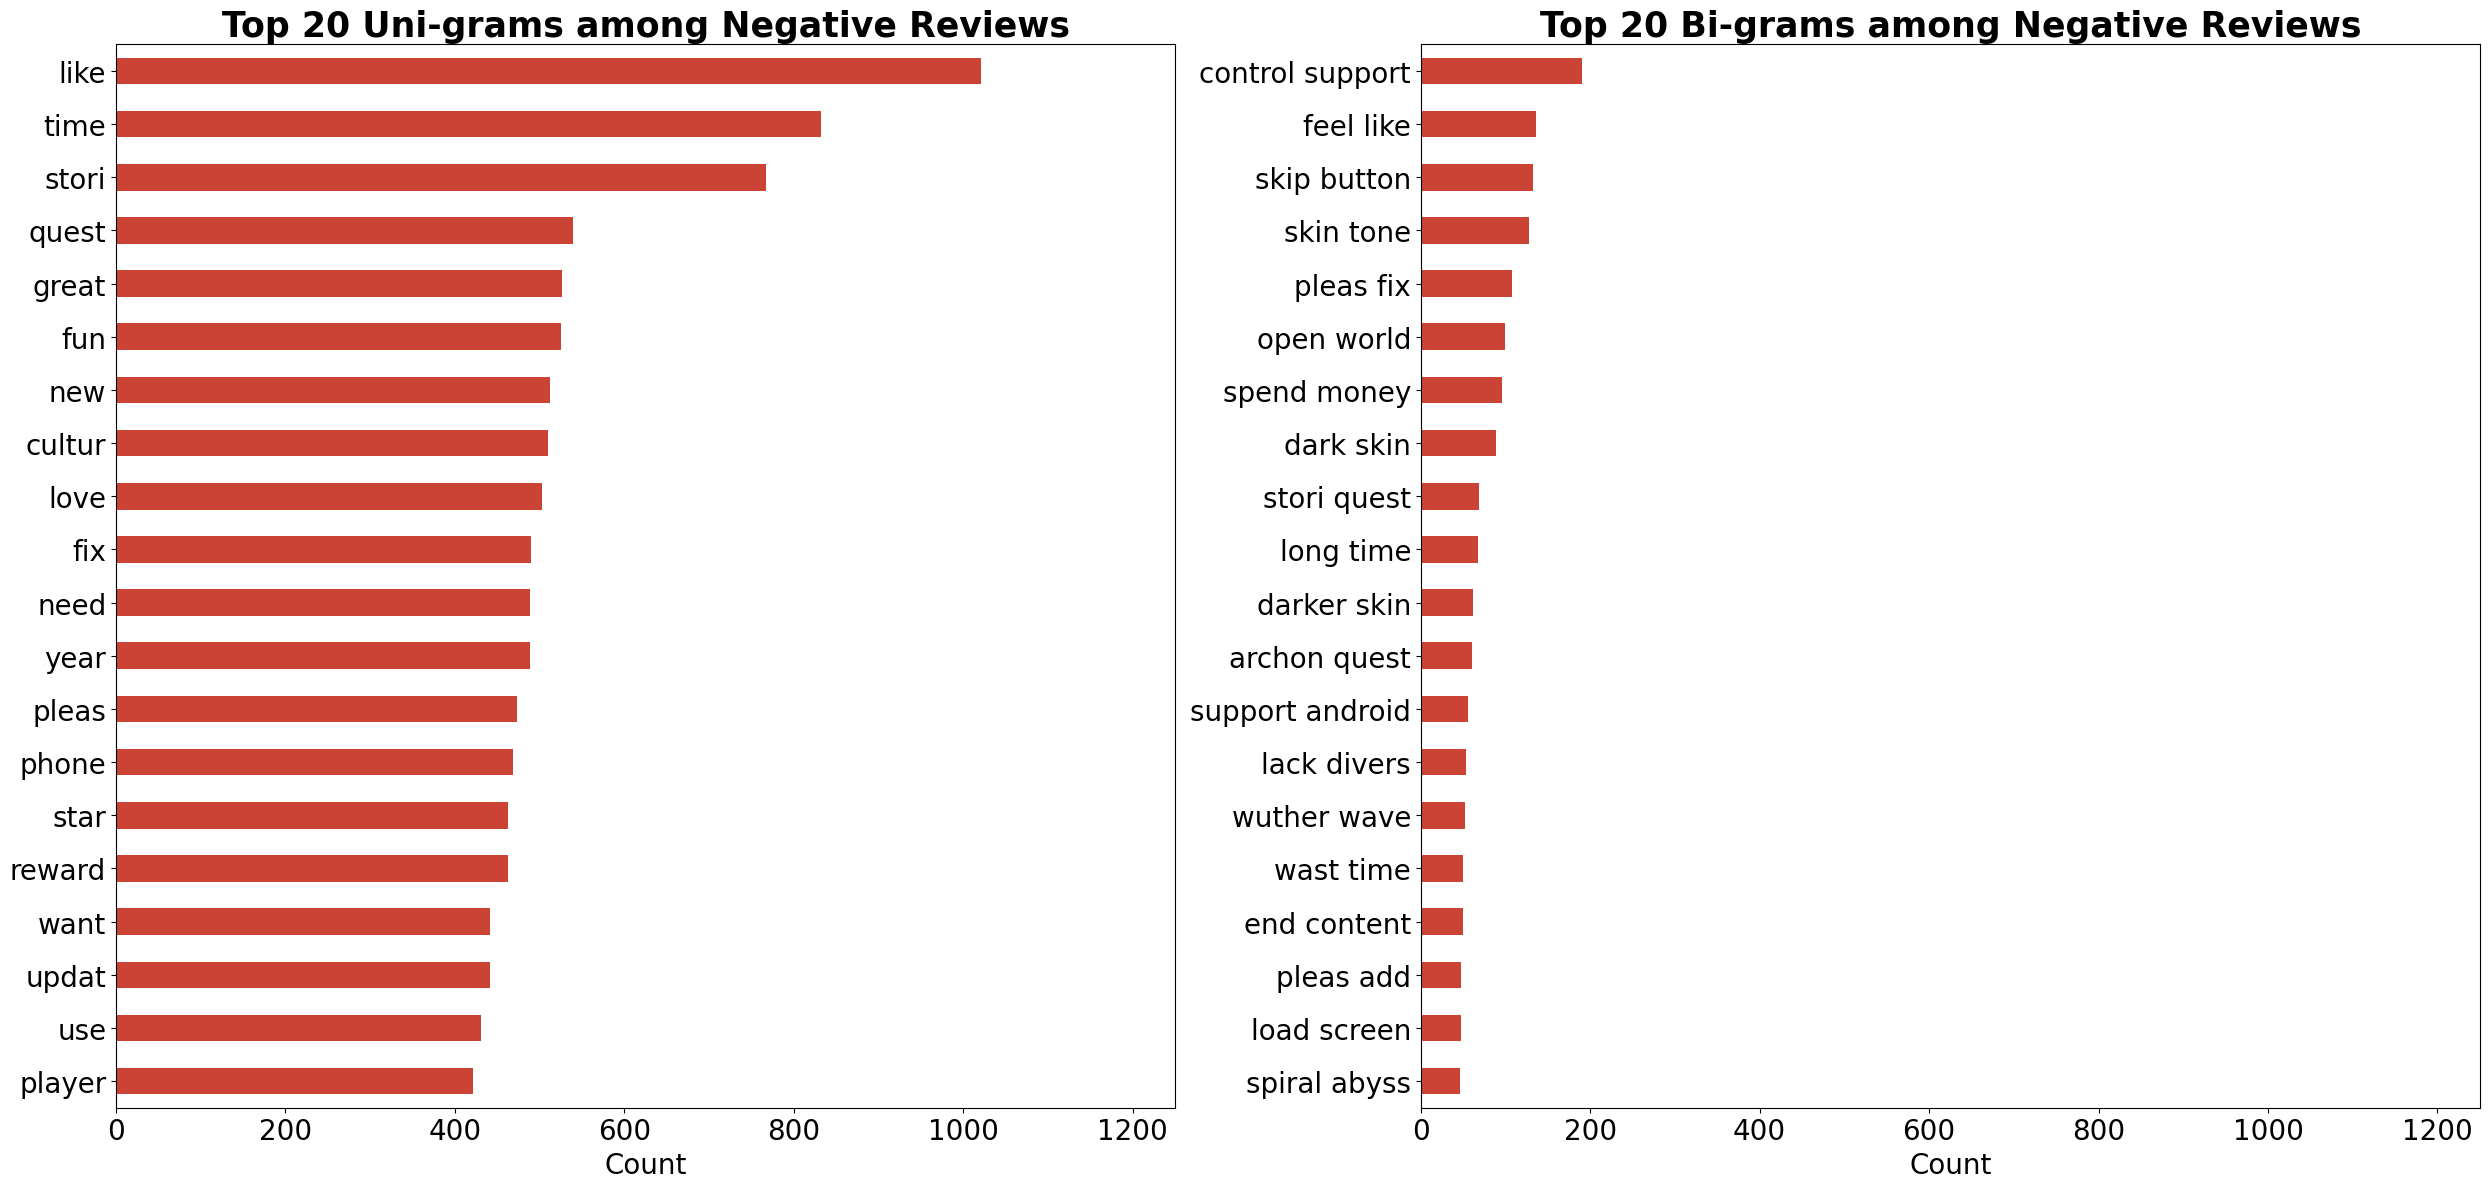

In [53]:
# Plot the uni-grams and bi-grams for negative reviews
barplot_cvec(
    df=train,
    target=1,
    titles=['Top 20 Uni-grams among Negative Reviews','Top 20 Bi-grams among Negative Reviews'], 
    color='#CB4335',
    xlimit=(0,1250)
)

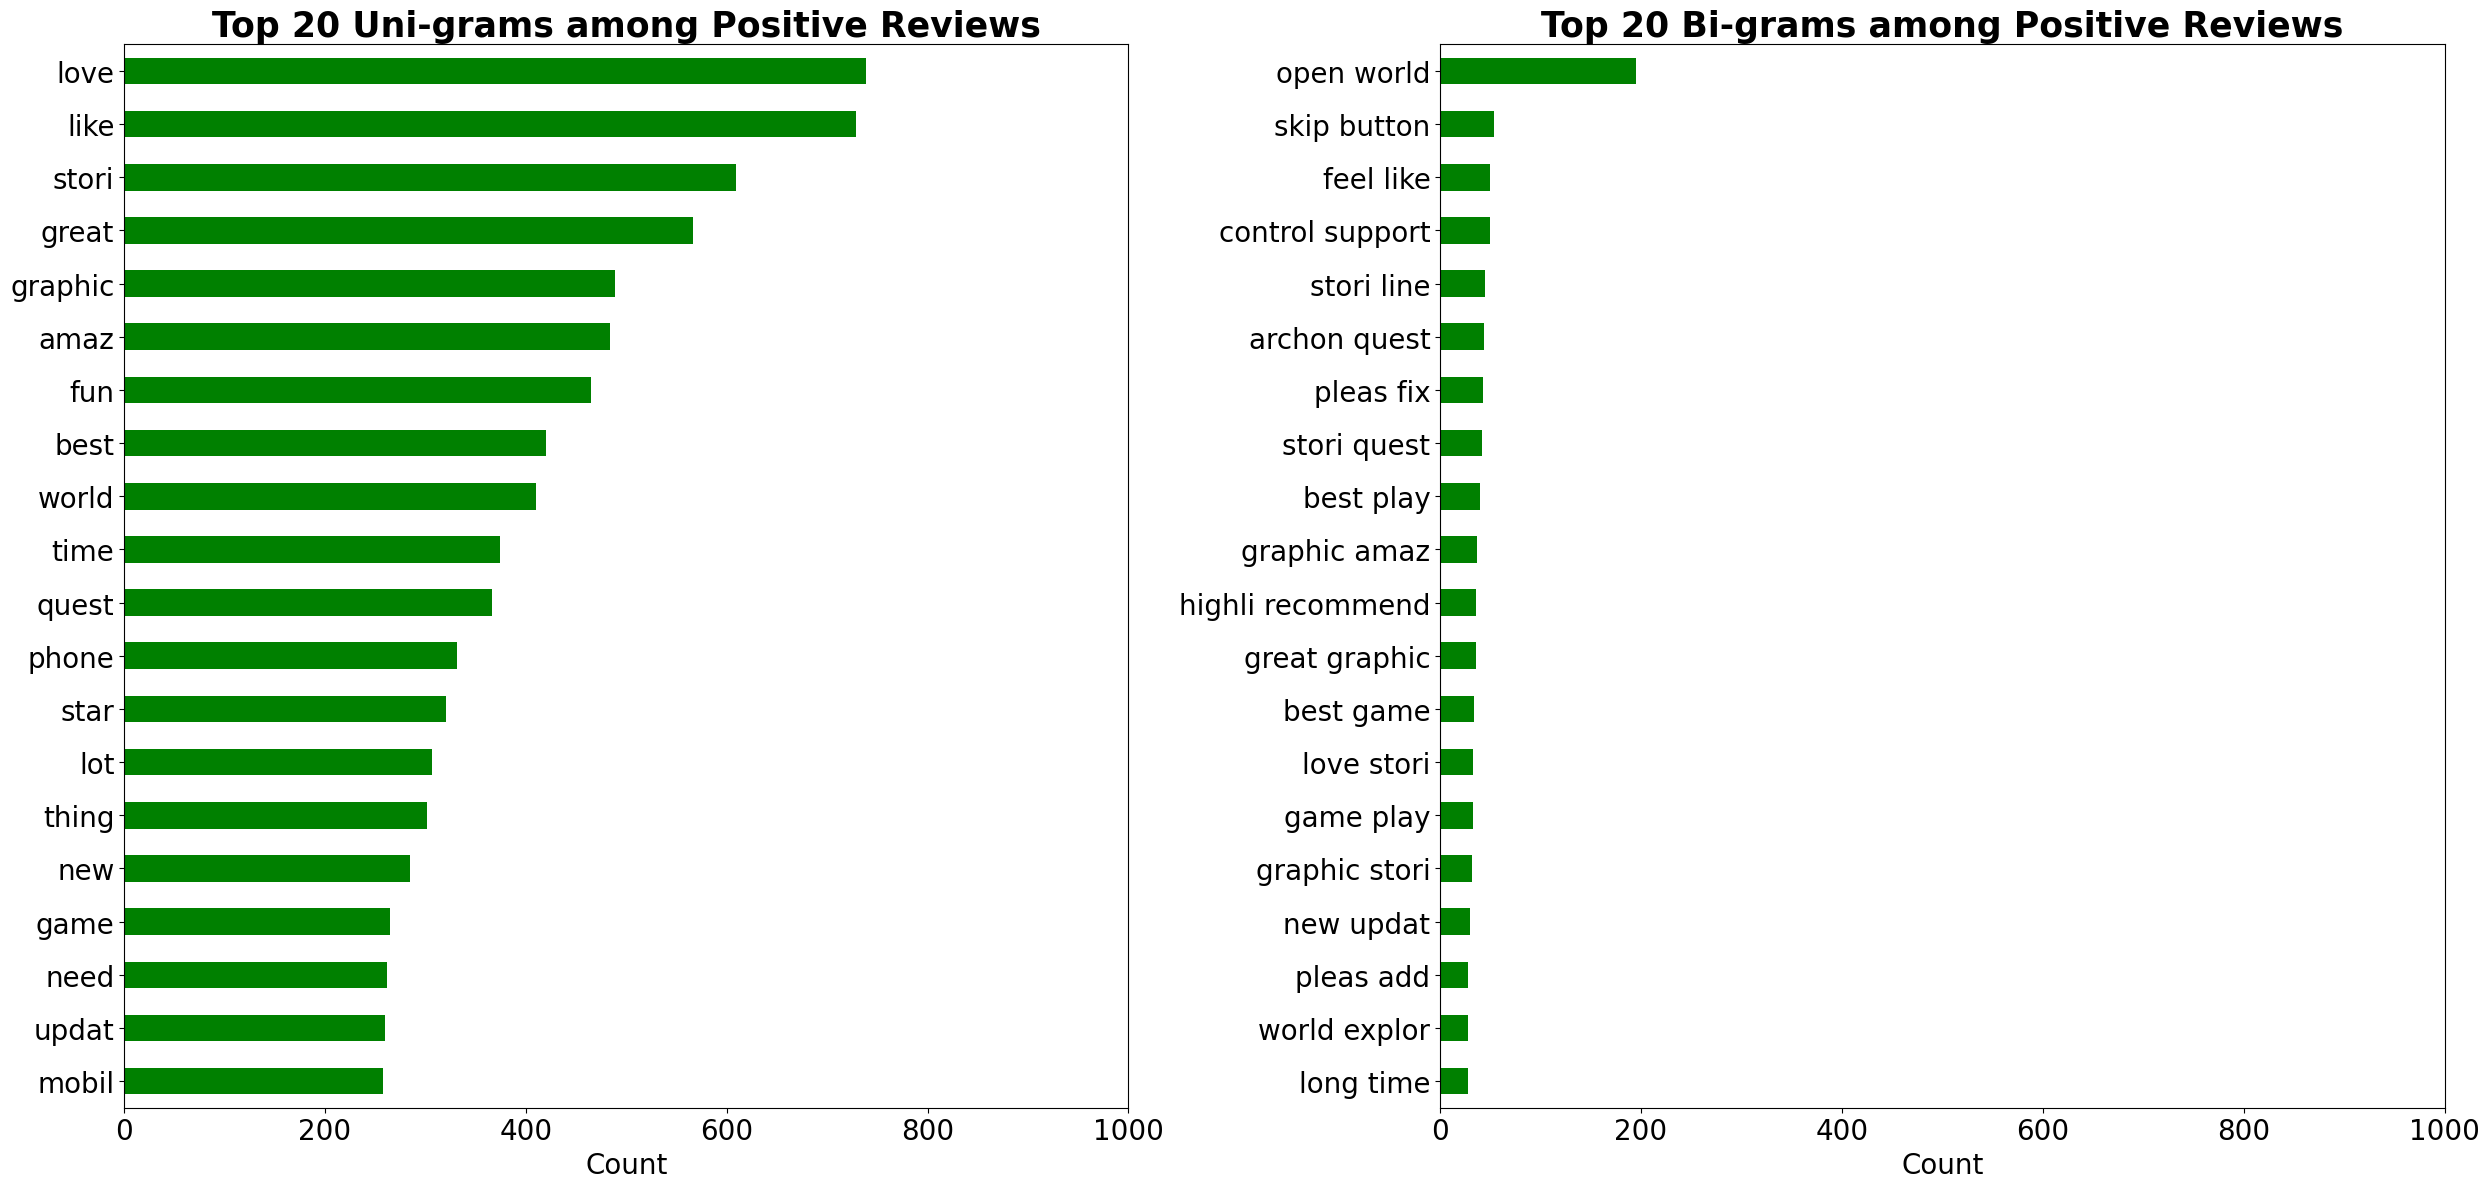

In [55]:
# Plot the uni-grams and bi-grams for positive reviews
barplot_cvec(
    df=train,
    target=0,
    titles=['Top 20 Uni-grams among Positive Reviews','Top 20 Bi-grams among Positive Reviews'], 
    color='#008000',
    xlimit=(0,1000)
)

#### 2.6 VADER sentiment analysis

[VADER](https://github.com/cjhutto/vaderSentiment) is a lexicon-based sentiment analysis tool that is specifically attuned to social media sentiments. We will use VADER to generate polarity scores for each review.

In [56]:
# Instantiate the sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

In [57]:
# Print a negative review in the training set
print(train.loc[389,'content'])

# VADER's polarity scores for the negative review
sia.polarity_scores(train.loc[389,'content'])

The absolutely disgusting racism that's rampant with Genshin is a huge turn off. I'm not spending any more money on a game that takes inspiration from poc's culture and can't even do the bare minimum and give them accurate representation. I have been playing the game for almost 4 years now, spent money on it too almost each month. I'm very disappointed that despite Sumeru's non existent representation raised issues before, we have the same issue again. Do better.


{'neg': 0.122, 'neu': 0.767, 'pos': 0.111, 'compound': -0.4704}

The compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1 (extremely negative sentiment) and +1 (extremely positive sentiment). VADER returns a compound score of -0.7351 in the example above, suggesting that it does well in predicting negative sentiment here. This is likely a result of VADER's ability to identify sentiment based on emojis, in addition to words. As VADER works well with emojis, slangs and even punctuations, we will evaluate VADER's performance on raw text, rather than the pre-processed text.